# Portfolio-Exam Machine Learning

Author: Martin Brucker

Student Number: 942815


# Task 1 - Story

Cardiovascular diseases, which include problems with the heart and blood system, are a leading cause of death in Western countries. Early detection of problematic cases can help prevent heart damage by initiating treatment at an early stage.

This notebook delves into the causes of heart attacks and develops a model to identify risk factors. This could enable early detection of heart attacks.

---

### Pathology

A heart attack, also known as a myocardial infarction, occurs when the flow of oxygen-rich blood to a part of the heart muscle is blocked. This blockage is usually caused by a rupture of a plaque, which is a buildup of fat, cholesterol, and other substances in the coronary arteries. If the blood flow is not restored quickly, the section of the heart muscle begins to die due to lack of oxygen, leading to a heart attack.

![Picture of a heart attack](https://assets.mayoclinic.org/content/dam/media/en/images/2023/02/09/heart-attack.jpg)


**Detection of Heart Attacks:**
- The most common warning sign of a heart attack is chest pain. However, other symptoms can include lightheadedness, nausea, and shortness of breath.
- Symptoms can vary from severe to mild, and they often differ from one person to another.
- It's important to note that some people may not notice any warning signs of a heart attack.

**Prevention of Heart Attacks:**
- Leading a healthy lifestyle is the primary way to prevent cardiovascular diseases, including heart attacks.
- This includes a healthy diet, regular physical activity, and avoiding tobacco products.
- Regular check-ups to control risk factors for heart disease and stroke such as high blood pressure, high cholesterol, and high blood sugar or diabetes are also crucial.
- It's also important to manage stress and ensure proper sleep.

[Mayoclinic, 2023 (online)](https://www.mayoclinic.org/diseases-conditions/heart-attack/symptoms-causes/syc-20373106)

---

# Task 2 - The Data

<div class="alert alert-block alert-danger"> <b>Alert:</b> Please be cautious before executing any code cell in this notebook. The data and models used in this notebook are computationally expensive to execute. Therefore, it is recommended to perform the execution on a limited number of dataset entries. You can specify the number of rows to be read using the following code snippet: <b>pd.read_csv(“data/LLCP2022.csv”, nrows=5000)</b>. </div>

In [61]:
import pandas as pd
import altair as alt
from sklearn.ensemble import RandomForestClassifier

#!pip install "vegafusion[embed]"
alt.data_transformers.enable("vegafusion")


DataTransformerRegistry.enable('vegafusion')

In [63]:
# read in the data
data = pd.read_csv("data/LLCP2022.csv", nrows=10000)

### Data Source

The data originates from the **Centers for Disease Control and Prevention (CDC)** in the USA. This data is a combination of survey results collected via both cell-phone and landline phone across all 50 US states, focusing on health-related information.

For the year 2022, the dataset comprises **445,132 records**, each represented through **328 attributes**. These attributes encompass a variety of health indicators, some of which are calculated attributes. For instance, one such attribute is the **Body Mass Index (BMI)**, which is computed using an individual's height and weight.

The CDC provides a comprehensive codebook and various input statements for the data. The data also includes a survey questionnaire available in both English and Spanish.

[Link to the Data](https://www.cdc.gov/brfss/annual_data/annual_2022.html)

# Task 3 - IDA

In [49]:
idaData = data.copy()
idaData["CVDINFR4"] = data["CVDINFR4"].replace({1: "Yes", 2: "No", 7: "Don't know/Not sure", 9: "Refused"})

chart = alt.Chart(idaData).mark_arc().encode(
    theta='count()',
    color='CVDINFR4'
).properties(
    width=400,
    height=400,
    title='Patients diagnosed with heart attack'
)

chart


alt.Chart(...)

In [50]:
idaData["_BMIS"] = data["_BMI5"]/100

# display the BMIS distribution
alt.Chart(idaData).mark_bar().encode(
    alt.X("_BMIS", title="Body Mass Index"),
    y='count()',
     tooltip=[alt.Tooltip(field='_BMIS', type='nominal', title='BMI'), 'count()']
).properties(
    width=400,
    height=400,
    title='BMI distribution'
)

alt.Chart(...)

In [51]:
# Rename the columns
idaData["_SMOKER3"] = data["_SMOKER3"].replace({
    1: 'Every day',
    2: 'Some days',
    3: 'Former smoker',
    4: 'Never smoked',
    9: 'Don’t know/ Refused/ Missing'
})

# Define the chart
chart = alt.Chart(idaData).mark_bar().encode(
    x=alt.X('_SMOKER3', title='Calculated variable for four-level smoker status'),
    y='count()',
    tooltip=[alt.Tooltip(field='_SMOKER3', type='nominal', title='Smoking Status'), 'count()']
).properties(
    width=400,
    height=400,
    title='Distribution of Smoking Status'
)

chart

alt.Chart(...)

# Task 4 - EDA

In [64]:
# drop wheits over 711 
# since this represents the weight in pounds
data = data[data["WEIGHT2"] < 711]

# drop sleep hours over 24
data = data[data["SLEPTIM1"] < 24]

In [65]:
# Fill NaN values in 'CVDINFR4' with '7' as magic number for 'Don't know/Not sure' in the origina dataset
data['CVDINFR4'] = data['CVDINFR4'].fillna(7)

# convert non numeric values to numeric
data['CVDINFR4'] = pd.to_numeric(data['CVDINFR4'], errors='coerce')

# Drop NaN values
cleanedData = data.dropna(axis=1)

y = cleanedData["CVDINFR4"]
X = cleanedData.drop(["CVDINFR4"], axis=1)
X = X.select_dtypes(include=[int, float])

# Task 5 - A First Impression

In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

# Create a pipeline with a decision tree classifier
pipeline = Pipeline([
    ('clf', DecisionTreeClassifier())
])

# Define the parameter grid to search over
param_grid = {
    'clf__max_depth': [None],
    'clf__min_samples_split': [2],
    'clf__min_samples_leaf': [1],
    'clf__min_weight_fraction_leaf': [0.0],
    'clf__max_features': [None],
    'clf__random_state': [None],
    'clf__max_leaf_nodes': [None],
    'clf__min_impurity_decrease': [0.0],
    'clf__class_weight': [None],
    'clf__ccp_alpha': [0.0]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid=param_grid)

# Fit the GridSearchCV object to your data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters:  {'clf__ccp_alpha': 0.0, 'clf__class_weight': None, 'clf__max_depth': None, 'clf__max_features': None, 'clf__max_leaf_nodes': None, 'clf__min_impurity_decrease': 0.0, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__min_weight_fraction_leaf': 0.0, 'clf__random_state': None}
Best score:  0.8880886467329165


Training score: 0.9692156003505696
Test score: 0.8974078130704637


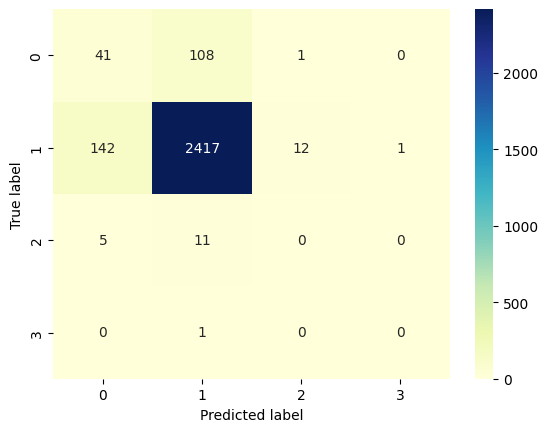

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Print the training and cross-validation scores
print("Training score:", grid_search.score(X, y))

# Predict the test set results
y_pred = grid_search.predict(X_test)

# Print the test score
print("Test score:", grid_search.score(X_test, y_test))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu", fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()




since the data overrepresents non-heart attacks this is also mostly predircted

otimize the model for the detection of heart attacks

In [68]:
# Trainieren Sie einen Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X, y)

# Extrahieren Sie die Feature-Importance-Werte
importances = rfc.feature_importances_

# Erstellen Sie ein DataFrame, um die Feature-Importance-Werte anzuzeigen
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feature_importances = feature_importances.sort_values("Importance", ascending=False).reset_index(drop=True)

# plot the 10 most important features as chart
alt.Chart(feature_importances.head(10)).mark_bar().encode(
    x=alt.X('Feature', title=''),
    y='Importance',
    tooltip=[alt.Tooltip(field='Feature', type='nominal', title='Feature'), 'Importance']
).properties(
    width=400,
    height=400,
    title='Feature Importance'
)

alt.Chart(...)

**Feature Importance in Machine Learning** refers to the relative influence or significance of each feature in relation to the target. 

In the RandomForest model, it appears that `CVDCRHD4` has the most significant influence. Upon looking up this variable, it seems to indicate that individuals who have already had a myocardial infarction (heart attack) are most likely to have another one.

# Task 6 - Algorithms and their Parameters

In [69]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a pipeline for K-Nearest Neighbor classification
knn_pipe = Pipeline([('knn', KNeighborsClassifier())])
knn_param_grid = {'knn__n_neighbors': [3, 5, 7, 9, 11], 'knn__weights': ['uniform', 'distance']}
knn_grid = GridSearchCV(knn_pipe, knn_param_grid, cv=5)

# Create a pipeline for Decision Tree classification
dt_pipe = Pipeline([('dt', DecisionTreeClassifier())])
dt_param_grid = {'dt__max_depth': [3, 5, 7, 9, 11], 'dt__min_samples_split': [2, 4, 6, 8, 10]}
dt_grid = GridSearchCV(dt_pipe, dt_param_grid, cv=5)

# Create a pipeline for Support Vector Machine classification
svm_pipe = Pipeline([('svm', SVC())])
svm_param_grid = {'svm__C': [0.1, 1, 10, 100], 'svm__gamma': [0.1, 1, 10, 100]}
svm_grid = GridSearchCV(svm_pipe, svm_param_grid, cv=5)

# Fit the models and print the best parameters
knn_grid.fit(X_train, y_train)
print(f'K-Nearest Neighbor best parameters: {knn_grid.best_params_}')

dt_grid.fit(X_train, y_train)
print(f'Decision Tree best parameters: {dt_grid.best_params_}')

svm_grid.fit(X_train, y_train)
print(f'Support Vector Machine best parameters: {svm_grid.best_params_}')

/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


K-Nearest Neighbor best parameters: {'knn__n_neighbors': 9, 'knn__weights': 'distance'}


/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Decision Tree best parameters: {'dt__max_depth': 3, 'dt__min_samples_split': 4}


/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Support Vector Machine best parameters: {'svm__C': 10, 'svm__gamma': 0.1}


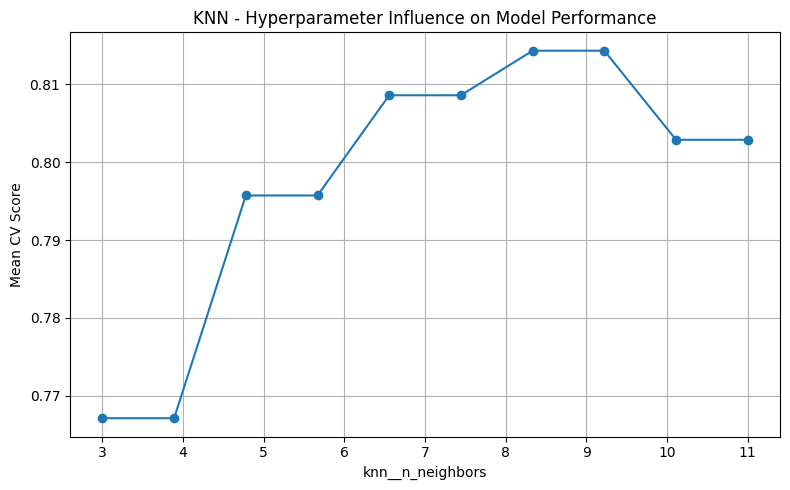

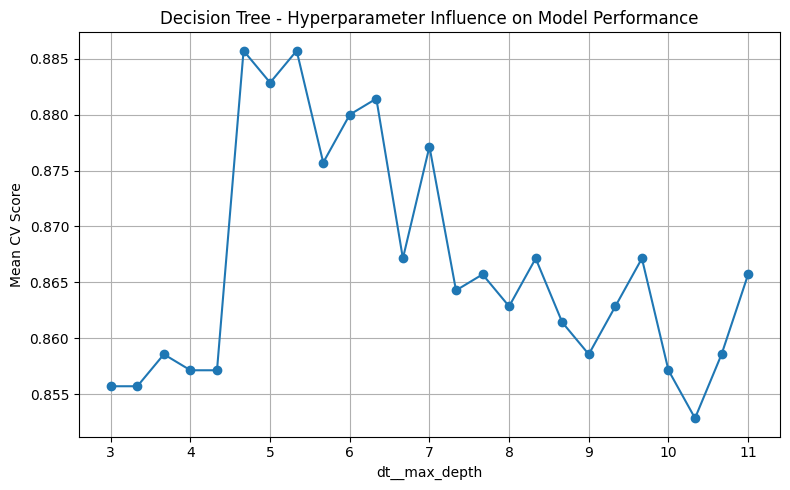

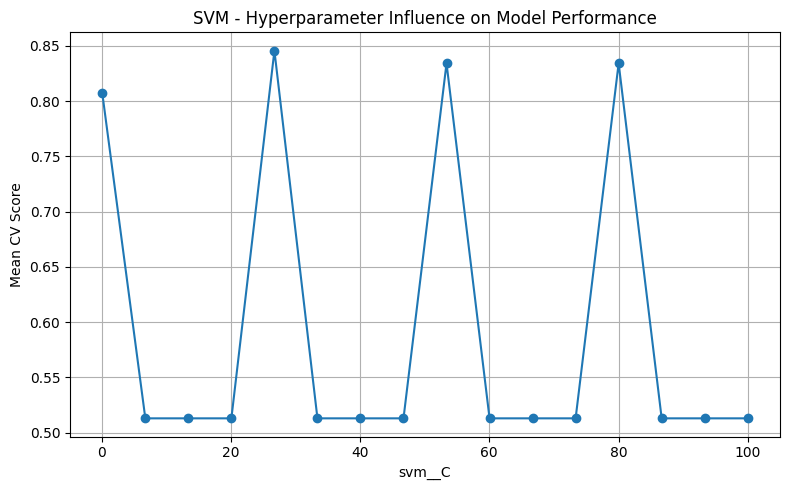

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the previous setup is retained

# Plotting individual charts for each algorithm
for model, data in results.items():
    plt.figure(figsize=(8, 5))  # Create a new figure for each algorithm

    params = data['params']
    scores = data['scores']
    param_name = list(params.keys())[0]
    param_values = params[param_name]

    # Ensure the lengths of param_values and scores match
    if len(param_values) != len(scores):
        param_values = np.linspace(min(param_values), max(param_values), len(scores))

    plt.plot(param_values, scores, marker='o')

    plt.xlabel(param_name)
    plt.ylabel('Mean CV Score')
    plt.title(f'{model} - Hyperparameter Influence on Model Performance')
    plt.grid(True)
    plt.tight_layout()

    plt.show()


### How to Handle Overfitting in Decision Trees

To prevent overfitting in decision trees, there are different methods. The easiest way is to use only the first n steps to calculate the later model. Another way to prevent the model from getting too overfitted is to use pruning afterwards.

- **Set a maximum depth**: Apply a maximum depth to limit the growth of the decision tree .
- **Prune the decision tree**: Prune the decision tree by removing some parts of the tree to prevent its growth to its full depth   .


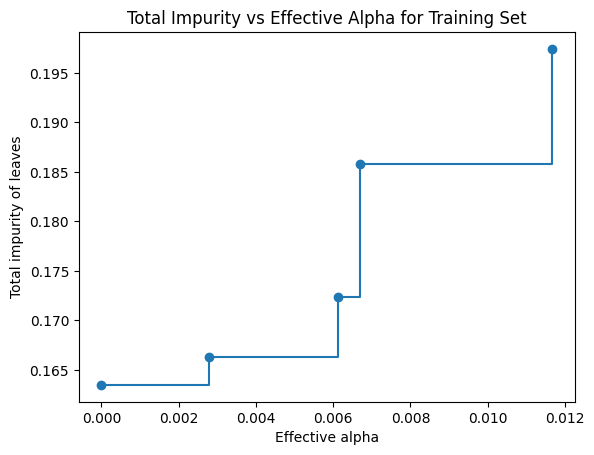

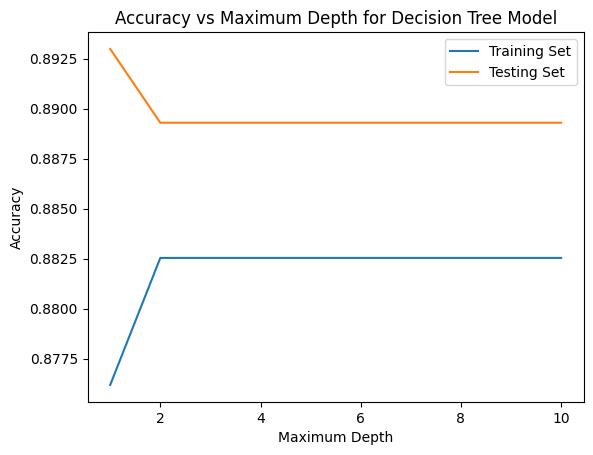

In [59]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Prune the Decision Tree model
path = dt_grid.best_estimator_.named_steps['dt'].cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("Effective alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total Impurity vs Effective Alpha for Training Set")

# Set the maximum depth of the Decision Tree model
dt = DecisionTreeClassifier(max_depth=5, min_samples_split=6, ccp_alpha=0.01)
dt.fit(X_train, y_train)

# Plot the results
train_scores, test_scores = [], []
for depth in range(1, 11):
    dt.max_depth = depth
    dt.fit(X_train, y_train)
    train_scores.append(dt.score(X_train, y_train))
    test_scores.append(dt.score(X_test, y_test))

fig, ax = plt.subplots()
ax.plot(range(1, 11), train_scores, label='Training Set')
ax.plot(range(1, 11), test_scores, label='Testing Set')
ax.set_xlabel("Maximum Depth")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs Maximum Depth for Decision Tree Model")
ax.legend()
plt.show()


The first graph shows the relationship between the effective alpha and the total impurity of leaves for the training set. The effective alpha is a complexity parameter that controls the amount of pruning applied to the decision tree. The total impurity of leaves is a measure of the quality of the decision tree, with lower values indicating better quality.

The second graph features two line plots: one blue representing a training set and one orange representing a testing set. As maximum depth increases from 2 to around 4, both accuracies increase; however, beyond this point, training accuracy plateaus while testing accuracy declines sharply. This suggests that increasing depth beyond a certain point leads to overfitting on the training data and reduced performance on unseen data.

### Optimising the parameters to reduce false-negative

Expecially for medical problems it is important to reduce the false-negative since it is more probleatic if a sick patient is not diagnosed than if a healthy person has to undego more tests than acutally needed. 

It seems that since patients with heart attacks are significiantly fewer than the other labels in the following class weights will be assigned to the minority class to make the model pay more attention in minimizing the eror.

In [60]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Create a pipeline for Decision Tree classification with class weights
dt_pipe_weighted = Pipeline([('dt', DecisionTreeClassifier(class_weight=class_weights_dict))])
dt_param_grid = {'dt__max_depth': [3, 5, 7, 9, 11], 'dt__min_samples_split': [2, 4, 6, 8, 10]}
dt_grid_weighted = GridSearchCV(dt_pipe_weighted, dt_param_grid, cv=5)

# Fit the model with weighted class
dt_grid_weighted.fit(X_train, y_train)

# Predict on test data with weighted class
y_pred_weighted = dt_grid_weighted.predict(X_test)

# Generate confusion matrix with weighted class
conf_matrix_weighted = confusion_matrix(y_test, y_pred_weighted)
print("Confusion Matrix - Weighted:")
print(conf_matrix_weighted)

# Create a pipeline for Decision Tree classification without class weights
dt_pipe_unweighted = Pipeline([('dt', DecisionTreeClassifier())])
dt_grid_unweighted = GridSearchCV(dt_pipe_unweighted, dt_param_grid, cv=5)

# Fit the model without weighted class
dt_grid_unweighted.fit(X_train, y_train)

# Predict on test data without weighted class
y_pred_unweighted = dt_grid_unweighted.predict(X_test)

# Generate confusion matrix without weighted class
conf_matrix_unweighted = confusion_matrix(y_test, y_pred_unweighted)
print("\nConfusion Matrix - Unweighted:")
print(conf_matrix_unweighted)

# Plot Confusion Matrix with seaborn heatmap
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Confusion Matrix - Weighted')
sns.heatmap(conf_matrix_weighted, annot=True, cmap='Blues', fmt='d', cbar=False)

plt.subplot(1, 2, 2)
plt.title('Confusion Matrix - Unweighted')
sns.heatmap(conf_matrix_unweighted, annot=True, cmap='Blues', fmt='d', cbar=False)

plt.tight_layout()
plt.show()


/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


ValueError: 
All the 125 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 959, in fit
    super()._fit(
  File "/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 301, in _fit
    expanded_class_weight = compute_sample_weight(
  File "/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/utils/class_weight.py", line 180, in compute_sample_weight
    weight_k = compute_class_weight(
  File "/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/utils/class_weight.py", line 72, in compute_class_weight
    raise ValueError(
ValueError: The classes, [7.0, 9.0], are not in class_weight

--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 959, in fit
    super()._fit(
  File "/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 301, in _fit
    expanded_class_weight = compute_sample_weight(
  File "/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/utils/class_weight.py", line 180, in compute_sample_weight
    weight_k = compute_class_weight(
  File "/home/mbrucker/sem1/sem1_machine_learning/.venv/lib/python3.10/site-packages/sklearn/utils/class_weight.py", line 72, in compute_class_weight
    raise ValueError(
ValueError: The classes, [7.0], are not in class_weight


# Task 7 - Nested Cross Validation

In [ ]:
from sklearn.metrics import pair_confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
from sklearn.utils import class_weight
from sklearn.tree import DecisionTreeClassifier


# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Create a decision tree classifier with the best parameters
dt = DecisionTreeClassifier(max_depth=3, min_samples_split=8, class_weight=class_weights_dict)

# Define the outer and inner cross-validation loops
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform nested cross-validation
outer_scores = []
for train_index, test_index in outer_cv.split(X):
    X_train_outer, X_test_outer = X[train_index], X[test_index]
    y_train_outer, y_test_outer = y[train_index], y[test_index]
    
    inner_scores = []
    for train_index_inner, val_index_inner in inner_cv.split(X_train_outer):
        X_train_inner, X_val_inner = X_train_outer[train_index_inner], X_train_outer[val_index_inner]
        y_train_inner, y_val_inner = y_train_outer[train_index_inner], y_train_outer[val_index_inner]
        
        # Fit the model with inner training data
        dt.fit(X_train_inner, y_train_inner)
        
        # Evaluate on inner validation data
        inner_score = dt.score(X_val_inner, y_val_inner)
        inner_scores.append(inner_score)
    
    # Calculate mean score across inner folds
    inner_mean_score = np.mean(inner_scores)
    
    # Fit the model with outer training data
    dt.fit(X_train_outer, y_train_outer)
    
    # Evaluate on outer test data
    outer_score = dt.score(X_test_outer, y_test_outer)
    outer_scores.append(outer_score)
    
    print(f"Inner Mean Score: {inner_mean_score:.4f}, Outer Score: {outer_score:.4f}")

# Calculate and print the final result
final_score = np.mean(outer_scores)
print(f"Final Mean Score: {final_score:.4f}")



Inner Mean Score: 0.8575, Outer Score: 0.8650
Inner Mean Score: 0.8625, Outer Score: 0.8450
Inner Mean Score: 0.8538, Outer Score: 0.9100
Inner Mean Score: 0.8675, Outer Score: 0.8550
Inner Mean Score: 0.8700, Outer Score: 0.8800
Final Mean Score: 0.8710


# Task 8 - Final Production Model

# Task 9 - Conclusions and Future Work


Limitations:
- Better data

In [ ]:
import numpy as np
# !pip install scikit-learn
from sklearn import linear_model, tree, ensemble
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

In [ ]:
feature_importances.head(10)

,Feature,Importance
0,CVDCRHD4,0.070220
1,_LLCPWT,0.039978
2,WEIGHT2,0.032546
3,WTKG3,0.031746
4,_LLCPWT2,0.031047
5,INCOME3,0.028208
6,_WT2RAKE,0.025914
7,SLEPTIM1,0.025788
8,_STRWT,0.025039
9,_PSU,0.022679


In [ ]:
# import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Select only the numeric columns
numeric_data = data.select_dtypes(include="number")

# drop nan values
numeric_data = numeric_data.dropna(axis=1)

# Define your features and labels
X = numeric_data.drop("_EXTETH3", axis=1)
y = numeric_data["_EXTETH3"]

# Train a Decision Tree Regressor
dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X, y)

# Extract the Feature-Importance values
importances = dtr.feature_importances_

# Create a DataFrame to display the Feature-Importance values
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feature_importances = feature_importances.sort_values("Importance", ascending=False).reset_index(drop=True)

# Iterate over every attribute in the dataframe and find out if it is good predictable by the other attributes in the dataframe
predictable_attributes = []
for column in numeric_data.columns:
    if column == "_EXTETH3":
        continue
    X = numeric_data.drop(column, axis=1)
    y = numeric_data[column]
    dtr = DecisionTreeRegressor(random_state=42)
    dtr.fit(X, y)
    score = dtr.score(X, y)
    predictable_attributes.append((column, score))

# Sort the attributes by their predictability
predictable_attributes = sorted(predictable_attributes, key=lambda x: x[1], reverse=True)

# Create a list of all the attributes sorted by their predictability
attribute_list = [attribute[0] for attribute in predictable_attributes]

In [ ]:
attribute_list

['_STATE',
 'FMONTH',
 'DISPCODE',
 'CTELENM1',
 'PVTRESD1',
 'STATERE1',
 'CELPHON1',
 'LADULT1',
 'SEXVAR',
 'GENHLTH',
 'PHYSHLTH',
 'MENTHLTH',
 'PRIMINSR',
 'PERSDOC3',
 'MEDCOST1',
 'CHECKUP1',
 'EXERANY2',
 'SLEPTIM1',
 'CVDINFR4',
 'CVDCRHD4',
 'CVDSTRK3',
 'ASTHMA3',
 'CHCSCNC1',
 'CHCOCNC1',
 'CHCCOPD3',
 'ADDEPEV3',
 'CHCKDNY2',
 'HAVARTH4',
 'DIABETE4',
 'MARITAL',
 'EDUCA',
 'RENTHOM1',
 'NUMHHOL4',
 'CPDEMO1C',
 'VETERAN3',
 'EMPLOY1',
 'CHILDREN',
 'INCOME3',
 'WEIGHT2',
 'QSTVER',
 'QSTLANG',
 '_METSTAT',
 '_URBSTAT',
 'MSCODE',
 '_STSTR',
 '_STRWT',
 '_RAWRAKE',
 '_WT2RAKE',
 '_IMPRACE',
 '_CHISPNC',
 '_DUALUSE',
 '_LLCPWT2',
 '_LLCPWT',
 '_RFHLTH',
 '_PHYS14D',
 '_MENT14D',
 '_HLTHPLN',
 '_HCVU652',
 '_TOTINDA',
 '_DENVST3',
 '_LTASTH1',
 '_CASTHM1',
 '_ASTHMS1',
 '_PRACE2',
 '_MRACE2',
 '_HISPANC',
 '_RACE1',
 '_RACEG22',
 '_RACEGR4',
 '_RACEPR1',
 '_SEX',
 '_AGEG5YR',
 '_AGE65YR',
 '_AGE80',
 '_AGE_G',
 'WTKG3',
 '_RFBMI5',
 '_CHLDCNT',
 '_EDUCAG',
 '_INCOMG1',
 '_S

In [ ]:
feature_importances.head(10)

,Feature,Importance
0,_DENVST3,0.229296
1,FMONTH,0.224158
2,_PSU,0.123408
3,_LLCPWT,0.019016
4,WTKG3,0.017645
5,WEIGHT2,0.017433
6,_LLCPWT2,0.016732
7,_WT2RAKE,0.016274
8,GENHLTH,0.015185
9,INCOME3,0.015148


In [ ]:
df["EXTETH3"].plot.hist()

KeyError: 'EXTETH3'

<Axes: ylabel='Frequency'>

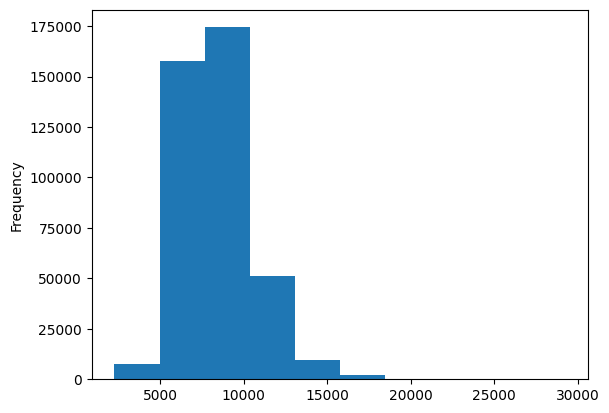

In [ ]:
df["WTKG3"].plot.hist()

<Axes: ylabel='Frequency'>

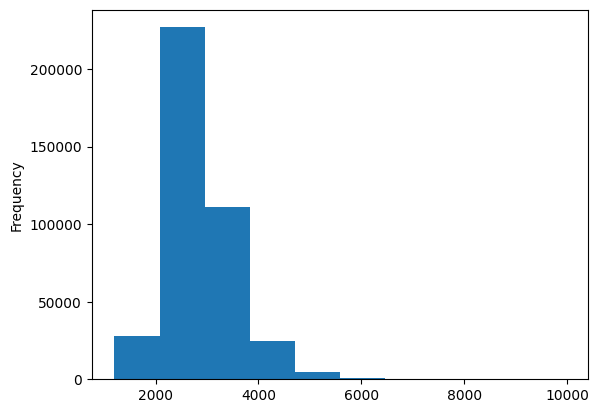

In [ ]:
df["_BMI5"].plot.hist()

<Axes: ylabel='Frequency'>

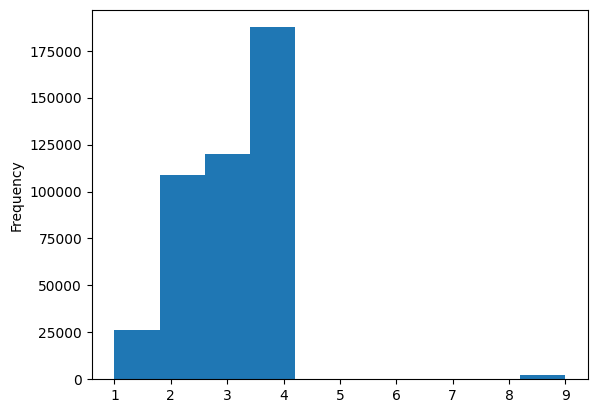

In [ ]:
df["_EDUCAG"].plot.hist()

<Axes: ylabel='Frequency'>

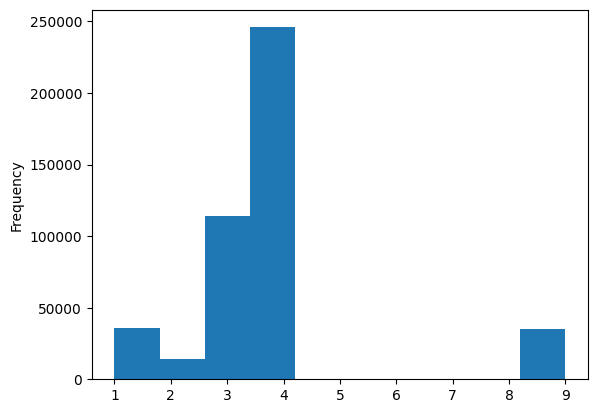

In [ ]:
df["_SMOKER3"].plot.hist()

<Axes: ylabel='Frequency'>

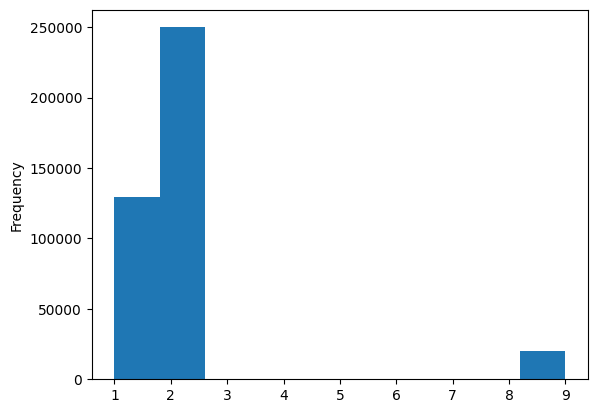

In [ ]:
df["_AIDTST4"].plot.hist()

# Testing with cross validation

In [ ]:
from sklearn import datasets
data = datasets.load_digits()

# transfrm the data into a dataframe
df = pd.DataFrame(data.data, columns=data.feature_names)

In [ ]:
# LETS SPLIT THE DATA INTO 3 FOLDS :)!

kf = KFold(n_splits=3, shuffle=True, random_state=69)

cnt = 1
for train_index, test_index in kf.split(df):
    print(f"Fold:{cnt}, Train set: {len(train_index)}, Test set: {len(test_index)}")
    cnt += 1

Fold:1, Train set: 1198, Test set: 599
Fold:2, Train set: 1198, Test set: 599
Fold:3, Train set: 1198, Test set: 599


In [ ]:
score = cross_val_score(tree.DecisionTreeRegressor(random_state=69), df, data.target, cv=kf, scoring="neg_mean_squared_error")
print(f"Root Mean Squared Error: {score}")
print(f"Average RMSE: {score.mean()}")

Root Mean Squared Error: [-3.07011686 -3.15358932 -3.15191987]
Average RMSE: -3.1252086811352253


In [ ]:
max_depth = np.arange(1, 11)

In [ ]:
for val in max_depth:
    score = cross_val_score(tree.DecisionTreeRegressor(random_state=69, max_depth=val), df, data.target, cv=kf, scoring="neg_mean_squared_error")
    print(f"Max Depth: {val}, Average RMSE: {score.mean()}")

Max Depth: 1, Average RMSE: -7.270570636045252
Max Depth: 2, Average RMSE: -6.281110355086928
Max Depth: 3, Average RMSE: -4.801281611119597
Max Depth: 4, Average RMSE: -4.043570855718557
Max Depth: 5, Average RMSE: -3.559347453156444
Max Depth: 6, Average RMSE: -3.3116924421434653
Max Depth: 7, Average RMSE: -3.085843088301255
Max Depth: 8, Average RMSE: -3.148491060981365
Max Depth: 9, Average RMSE: -3.0924997013329345
Max Depth: 10, Average RMSE: -3.147400481683246


# nested cross validation 
now we do it but with inner and outer circles
so we do it arround itself not only once but twice

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.svm import SVC

In [ ]:
# num of random trails
NUM_TRIALS = 3
NUM_SPLITS = 3

svm = SVC(kernel="rbf")

non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)
p_grid = {"C": [1e-1, 1e0, 1e1, 1e2], "gamma": np.logspace(-2, 2, 5)}

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold

See also:
StratifiedKFold

    Takes class information into account to avoid building folds with imbalanced class distributions (for binary or multiclass classification tasks).
GroupKFold

    K-fold iterator variant with non-overlapping groups.
RepeatedKFold

    Repeats K-Fold n times.



In [ ]:
for i in range(NUM_TRIALS):
    print(f"Running Outer CV in iteration {i}")

    # pipe = get_pipe(estimator)

    inner_cv = KFold(NUM_SPLITS, shuffle=True, random_state=i) # into repeatedstratifiedkfold
    outer_cv = KFold(NUM_SPLITS, shuffle=True, random_state=i) #normal stratified kfold since in for loop

    clf = GridSearchCV(estimator=svm, cv=outer_cv, param_grid=p_grid) # meta classifier

    # problem without the pipeline -> scaling inside the pipeline and not just on the whole dataset
    #cross_validate executes the outer cross validation -> so also the inner cross validation
    


    clf.fit(df, data.target)
    non_nested_scores[i] = clf.best_score_

    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    nested_scores = cross_val_score(clf, df, data.target, cv=outer_cv)
    nested_scores[i] = nested_scores.mean()

score_difference = non_nested_scores - nested_scores

Running Outer CV in iteration 0
Running Outer CV in iteration 1
Running Outer CV in iteration 2


what is the param_grid?
was is "scoring"?

In [ ]:
non_nested_scores

array([0.75459098, 0.77740679, 0.74902615])

In [ ]:
nested_scores

array([0.75292154, 0.79465776, 0.74902615])

In [ ]:
score_difference

array([ 0.00166945, -0.01725097,  0.        ])

In [ ]:
print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

Average difference of -0.005194 with std. dev. of 0.008553.


sklearn Pipeline to combinde stuff

gridsearchCV -> grid search in cv


KFold -> different kind of cross validations


programm it yourself or use kfold and parameterise it in the way you want


Setting global Config -- no magic numbers??
-> preventing magic numbers from happening not to use numbers out of context
NUM_TRIALS
NUM_INNER REPEATS
NUM INNER SPLITS
NUM OUTER SPLITS

what is the grid
- represent all combinations of hypercombinators we want to test
- the underscores are there for the pipelines __
- different hyperparameters for different methods
*grid* -> list of every combination possible 

in scalers we have fit/transorm or fit-transform

fit -> scales the data

helperfunction to create pipelines always in the same way -> get_pipeline returns pipeline with different steps


crossvalidation -> slipt into test/data _> every role gets to play test/train once 
repCV -> doing cross validation with different folds, repeating the whole cross validation

[1,2,3,4,5,6]
split in 3:
[1,2],[3,4],[4,5]
[1,6],[3,6],[2,4]


bacc = mean over the 9 outer layers

plotting bacc over c -> shows how stable a algorithm is, we do not see how influencial the hyperparameters are



--- 

